In [1]:
import cv2, os, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from glob import glob
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

In [3]:
seed = 2020
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
path = 'dataset/dogs-vs-cats/train'

In [5]:
ROW, COL = 96, 96

dogs, cats = [], []
y_dogs, y_cats = [], []

In [6]:
dog_path = os.path.join(path, 'dog.*')
for dog_img in glob(dog_path):
    dog = cv2.imread(dog_img)
    dog = cv2.cvtColor(dog, cv2.COLOR_BGR2GRAY)
    dog = cv2.resize(dog, (ROW, COL))
    dog = image.img_to_array(dog)
    dogs.append(dog)
print('All dog images loaded')

All dog images loaded


In [7]:
cat_path = os.path.join(path, 'cat.*')
for cat_img in glob(cat_path):
    cat = cv2.imread(cat_img)
    cat = cv2.cvtColor(cat, cv2.COLOR_BGR2GRAY)
    cat = cv2.resize(cat, (ROW, COL))
    cat = image.img_to_array(cat)
    cats.append(cat)
print('All cat images loaded')

All cat images loaded


In [8]:
def shows(label):
    plt.figure(figsize=(12, 8))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        img = image.array_to_img(random.choice(label))
        plt.imshow(img, cmap=plt.get_cmap('gray'))
        plt.axis('off')

    plt.show()

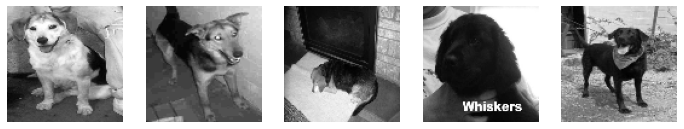

In [9]:
shows(dogs)

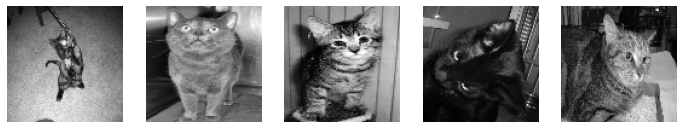

In [10]:
shows(cats)

In [11]:
y_dogs = [1 for item in enumerate(dogs)]
y_cats = [0 for item in enumerate(cats)]

In [12]:
dogs = np.asarray(dogs).astype('float32') / 255
cats = np.asarray(cats).astype('float32') / 255
y_dogs = np.asarray(y_dogs).astype('int32')
y_cats = np.asarray(y_cats).astype('int32')

In [13]:
dogs.shape, y_dogs.shape

((12500, 96, 96, 1), (12500,))

In [14]:
x_data = np.concatenate((dogs, cats), axis = 0)
y_data = np.concatenate((y_dogs, y_cats), axis = 0)

In [15]:
y_data = tf.keras.utils.to_categorical(y_data, 2)

In [16]:
x_train, x_test, y_train, t_test = train_test_split(x_data, y_data, test_size=0.2, random_state = seed)

In [17]:
model = Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu", input_shape=(ROW, COL, 1)),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation="softmax")
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 147456)            0         
_________________________________________________________________
dropout (Dropout)            (None, 147456)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               18874496  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [19]:
model.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Nadam(),
             metrics = ['accuracy'])

In [20]:
modelpath = "../model/dogsvscats-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = keras.callbacks.ModelCheckpoint(modelpath,verbose=1, save_best_only=True)

In [21]:
history = model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=32, callbacks=[checkpointer])

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
15968/16000 [============================>.] - ETA: 0s - loss: 0.6862 - accuracy: 0.5894
Epoch 00001: val_loss improved from inf to 0.61194, saving model to ../model/dogsvscats-01-0.6119.hdf5
16000/16000 [==============================] - 259s 16ms/sample - loss: 0.6863 - accuracy: 0.5894 - val_loss: 0.6119 - val_accuracy: 0.6920
Epoch 2/10
15968/16000 [============================>.] - ETA: 0s - loss: 0.5676 - accuracy: 0.7036
Epoch 00002: val_loss improved from 0.61194 to 0.52384, saving model to ../model/dogsvscats-02-0.5238.hdf5
16000/16000 [==============================] - 256s 16ms/sample - loss: 0.5675 - accuracy: 0.7035 - val_loss: 0.5238 - val_accuracy: 0.7400
Epoch 3/10
15968/16000 [============================>.] - ETA: 0s - loss: 0.4801 - accuracy: 0.7711
Epoch 00003: val_loss improved from 0.52384 to 0.51665, saving model to ../model/dogsvscats-03-0.5166.hdf5
16000/16000 [==============================] - 254s 16

In [25]:
del model

In [26]:
model = keras.models.load_model('../model/dogsvscats-04-0.4814.hdf5')

In [27]:
model.evaluate(x_test , t_test, verbose=0)

[0.4883257415771484, 0.7652]